In [1]:
import os
import torch
import numpy as np
import math
from tqdm import tqdm
import wandb
import pickle
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
import seaborn as sns

from data.rna_object import RNA
from data.dataloader import get_train_test_dataloaders, RNATorsionalAnglesDataset, collate_fn

from torch.utils.data import DataLoader

from models.transformer import TorsionalAnglesTransformerDecoder

/ssd_scratch/users/sriram.devata/torrna/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
perfect_pdb_files_train_val_test_path="/home2/sriram.devata/rna_project/cdhit/torrna_train_val_test.pkl"

with open(perfect_pdb_files_train_val_test_path, "rb") as fp:
        training_pdbs, validation_pdbs, testing_pdbs = pickle.load(fp)
testing_pdbs = [x.replace('_','') for x in testing_pdbs]

In [3]:
dict_attr = type('dict_attr', (object,), {})
args = dict_attr()
args.lr = 2e-4
args.embeddim = 640
args.hiddendim = 256
args.numheads = 4
args.numlayers = 3
args.dropout = 0.2
args.tol = 5

model = TorsionalAnglesTransformerDecoder(embed_dim=args.embeddim, hidden_dim=args.hiddendim, num_heads=args.numheads, num_layers=args.numlayers, dropout=args.dropout)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.load_state_dict(torch.load(f"/home2/sriram.devata/rna_project/rna_transformer/checkpoints/torrna_best_model_rna_transformer_{args.lr}_{args.embeddim}_{args.hiddendim}_{args.numheads}_{args.numlayers}_{args.dropout}_{args.tol}.pkl", map_location=device))
model.eval()
print(model)

TorsionalAnglesTransformerDecoder(
  (transformer_decoder): TransformerDecoder(
    (layers): ModuleList(
      (0): TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=640, out_features=640, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=640, out_features=640, bias=True)
        )
        (linear1): Linear(in_features=640, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=640, bias=True)
        (norm1): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (norm3): LayerNorm((640,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (dropout3): Dropout(p=0.2, inplace=

In [4]:
# ------------------- Helper functions -------------------

all_dihedral_angle_names = ["alpha ($\\alpha$)" ,"beta ($\\beta$)" ,"gamma ($\\gamma$)" ,"delta ($\\delta$)" ,"chi ($\\chi$)" ,"epsilon ($\\epsilon$)" ,"zeta ($\\zeta$)" ,"eta ($\\eta$)" ,"theta ($\\theta$)"]

def convert_to_rad_and_back_to_degree(cur_res_spot_rna_pred_angles):

        final_degree_angles = list()
        for each_angle in cur_res_spot_rna_pred_angles:
                torsion_angle = torch.tensor([each_angle * math.pi / 180])
                final_degree_angle = torch.arctan2(torch.sin(torsion_angle),torch.cos(torsion_angle)).item() * 180 / math.pi
                final_degree_angles.append(final_degree_angle)

        return final_degree_angles

def make_rad_angle_tensor_to_deg_angle_list(rad_angle_tensor):

        constructed_angles = list()
        for each_angle_idx in range(len(all_dihedral_angle_names)):
                cos_angle = rad_angle_tensor[2*each_angle_idx]
                sin_angle = rad_angle_tensor[2*each_angle_idx+1]
                rad_angle = torch.arctan2(sin_angle,cos_angle)
                deg_angle = rad_angle.item() * 180 / math.pi
                constructed_angles.append(deg_angle)

        return constructed_angles

def calculate_mae(predicted, groundtruth, prediction_method="Unknown"):

        angle_errors_to_export = list()
        all_angle_errors = list()
        for each_angle_idx in range(len(all_dihedral_angle_names)):
                all_angle_errors.append(list())
                angle_errors_to_export.append(list())

        for each_rna_idx in range(len(predicted)):

                for each_angle_idx in range(len(all_dihedral_angle_names)):
                        angle_errors_to_export[each_angle_idx].append(list())

                for each_residue_idx in range(len(predicted[each_rna_idx])):

                        predicted_angles = predicted[each_rna_idx][each_residue_idx]
                        gt_angles = groundtruth[each_rna_idx][each_residue_idx]

                        for each_angle_idx in range(len(all_dihedral_angle_names)):

                                if prediction_method == "Random Baseline":
                                        difference = abs(predicted_angles[each_angle_idx] - gt_angles[each_angle_idx])
                                        difference = sum(difference)/len(difference)
                                        difference = difference.item()
                                else:
                                        difference = abs(predicted_angles[each_angle_idx] - gt_angles[each_angle_idx])

                                difference = min(difference, 360-difference)
                                if math.isnan(difference):
                                        continue
                                all_angle_errors[each_angle_idx].append(difference)
                                angle_errors_to_export[each_angle_idx][-1].append(difference)

        return_maes = list()
        all_errors = list()

#         print(f"\n----------\nMAEs for all dihedral angles predicted by {prediction_method}")
        for each_angle_idx in range(len(all_dihedral_angle_names)):
                mae = sum(all_angle_errors[each_angle_idx])/len(all_angle_errors[each_angle_idx])
                return_maes.append(mae)
                all_errors.append(all_angle_errors[each_angle_idx])
#                 print(f"{all_dihedral_angle_names[each_angle_idx]}: {mae:.3f}")

        return return_maes, all_errors, angle_errors_to_export



In [5]:
data_to_plot = list()

rnapot_decoys_directory = "/home2/sriram.devata/rna_project/rnapot/decoys/"
for each_decoy_idx, each_decoy_dir in enumerate(os.listdir(rnapot_decoys_directory)):
    if not os.path.isdir(f"{rnapot_decoys_directory}/{each_decoy_dir}"):
        continue
        
    if each_decoy_dir.upper() not in testing_pdbs:
        continue
        
    cur_decoy_dir = f"{rnapot_decoys_directory}/{each_decoy_dir}"
    
    decoy_original_rna_object = RNA(f"{cur_decoy_dir}/{each_decoy_dir}.pdb", calc_rna_fm_embeddings=True, load_dssr_dihedrals=True, load_coords=False, dssr_path=cur_decoy_dir)

    # --- Predict the dihedral angles with TorRNA ---
    rna_fm_embeddings = decoy_original_rna_object.rna_fm_embeddings.unsqueeze(0).to(device)
    initial_embeddings = decoy_original_rna_object.rna_fm_initial_embeddings.unsqueeze(0).to(device)
    gt_torsional_angles = decoy_original_rna_object.dssr_torsion_angles.unsqueeze(0).to(device)
    padding_mask = torch.sum(torch.abs(gt_torsional_angles), dim=-1) < 1e-5
    output = model(rna_fm_embeddings, padding_mask, initial_embeddings).detach().cpu()[0]
    all_predicted_angles_original_pdb = list()
    for each_residue_idx in range(len(output)):
        if padding_mask[0][each_residue_idx]:
            continue	# True if this residue is padded
        predicted_angles = make_rad_angle_tensor_to_deg_angle_list(output[each_residue_idx])
        all_predicted_angles_original_pdb.append(predicted_angles)

        
        
    each_decoy_all_rmsds = pd.read_csv(f"{rnapot_decoys_directory}/{each_decoy_dir}/{each_decoy_dir}.rmsd", delim_whitespace=True)
    each_decoy_all_rmsds.rename(columns = {'#':'Structure', 'STRUCTURE':'PROB', 'PROB':"RMSD-C3'", "RMSD-C3'":"GDT-C3'", "GDT-C3'":"RMSD-ALL", "RMSD-ALL":"GDT-ALL", "GDT-ALL":"MAE"}, inplace = True) 
    each_decoy_all_rmsds = each_decoy_all_rmsds[["Structure", "RMSD-ALL", "GDT-ALL", "MAE"]]
    each_decoy_all_rmsds['MAE'] = each_decoy_all_rmsds['MAE'].astype('object')
    
    for row_index, row in tqdm(each_decoy_all_rmsds.iterrows(), total=each_decoy_all_rmsds.shape[0]):

        # get the DSSR angles of each of the structures 
        each_structure_rna_object = RNA(f"{cur_decoy_dir}/{row['Structure']}.pdb", calc_rna_fm_embeddings=True, load_dssr_dihedrals=True, load_coords=False, dssr_path=cur_decoy_dir)

        each_structure_angles = each_structure_rna_object.dssr_torsion_angles.unsqueeze(0).to(device)
        all_each_structure_angles = list()
        for each_residue_idx in range(len(each_structure_angles[0])):
            cur_res_gt_angles = make_rad_angle_tensor_to_deg_angle_list(each_structure_angles[0][each_residue_idx])
            all_each_structure_angles.append(cur_res_gt_angles)
        
        if len(all_predicted_angles_original_pdb) != len(all_each_structure_angles):
            continue # some of the decoys have a different number of residues for some reason
            
        all_maes, all_predicted_errors, angle_errors_to_export = calculate_mae([all_predicted_angles_original_pdb], [all_each_structure_angles], prediction_method="TorRNA")
        
        all_maes = np.array(all_maes, dtype='object')
        each_decoy_all_rmsds.at[row_index, 'MAE'] = all_maes
        
        
    all_dihedral_angle_names = ["alpha ($\\alpha$)" ,"beta ($\\beta$)" ,"gamma ($\\gamma$)" ,"delta ($\\delta$)" ,"chi ($\\chi$)" ,"epsilon ($\\epsilon$)" ,"zeta ($\\zeta$)" ,"eta ($\\eta$)" ,"theta ($\\theta$)"]


    data = pd.DataFrame(columns=["RMSD", "GDT-ALL", "MAE", "Angle"])

    df_loc = 0
    all_angles_maes = [list() for _ in all_dihedral_angle_names]
    for row_index, row in tqdm(each_decoy_all_rmsds.iterrows(), total=each_decoy_all_rmsds.shape[0]):
        for each_angle_id, each_angle_name in enumerate(all_dihedral_angle_names):
            if not isinstance(row["MAE"], np.ndarray):
                continue
            data.loc[df_loc] = [row["RMSD-ALL"], row["GDT-ALL"], row["MAE"][each_angle_id], each_angle_name]
            df_loc += 1

        #all_angles_maes[each_angle_id] = [x[each_angle_id] for x in each_decoy_all_rmsds['MAE']]    

    # print(data)
    
    if data.shape[0] < 20: # if there is only one RMSD 0.0 entry for the plot, there will be 9 points in total or so
        continue
        
    data_to_plot.append((each_decoy_dir, data))
        
#     fig, (ax1, ax2) = plt.subplots(1,2, figsize=(30, 10))
#     plt.rcParams.update({'font.size': 25})
#     matplotlib.rc('xtick', labelsize=22) 
#     matplotlib.rc('ytick', labelsize=22)

#     sns.scatterplot(data=data, x="RMSD", y="MAE", hue="Angle", style="Angle", ax=ax1)
#     sns.scatterplot(data=data, x="GDT-ALL", y="MAE", hue="Angle", style="Angle", ax=ax2)
#     ax1.legend().set_visible(False)
#     ax1.set_xlabel('Root Mean Square Deviation (RMSD)')
#     ax1.set_ylabel('Mean Absolute Error (MAE)')
#     ax2.legend().set_visible(False)
#     ax2.set_xlabel('Global Distance Test (GDT)')
#     ax2.set_ylabel('Mean Absolute Error (MAE)')

#     handles, labels = plt.gca().get_legend_handles_labels()
#     plt.legend(handles, labels, bbox_to_anchor=(1.23, 1.02), loc='upper right')

#     fig.suptitle(f"MAE vs RMSD and MAE vs GDT plots of PDB ID {each_decoy_dir}")
#     plt.tight_layout()
#     plt.savefig(f'images/gdt_rmsd_mae_{each_decoy_dir}.svg', dpi=300)
#     plt.show()
#     break



100%|██████████| 501/501 [00:00<00:00, 10906.91it/s]


/tmp/ipykernel_20136/2792183084.py:58: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


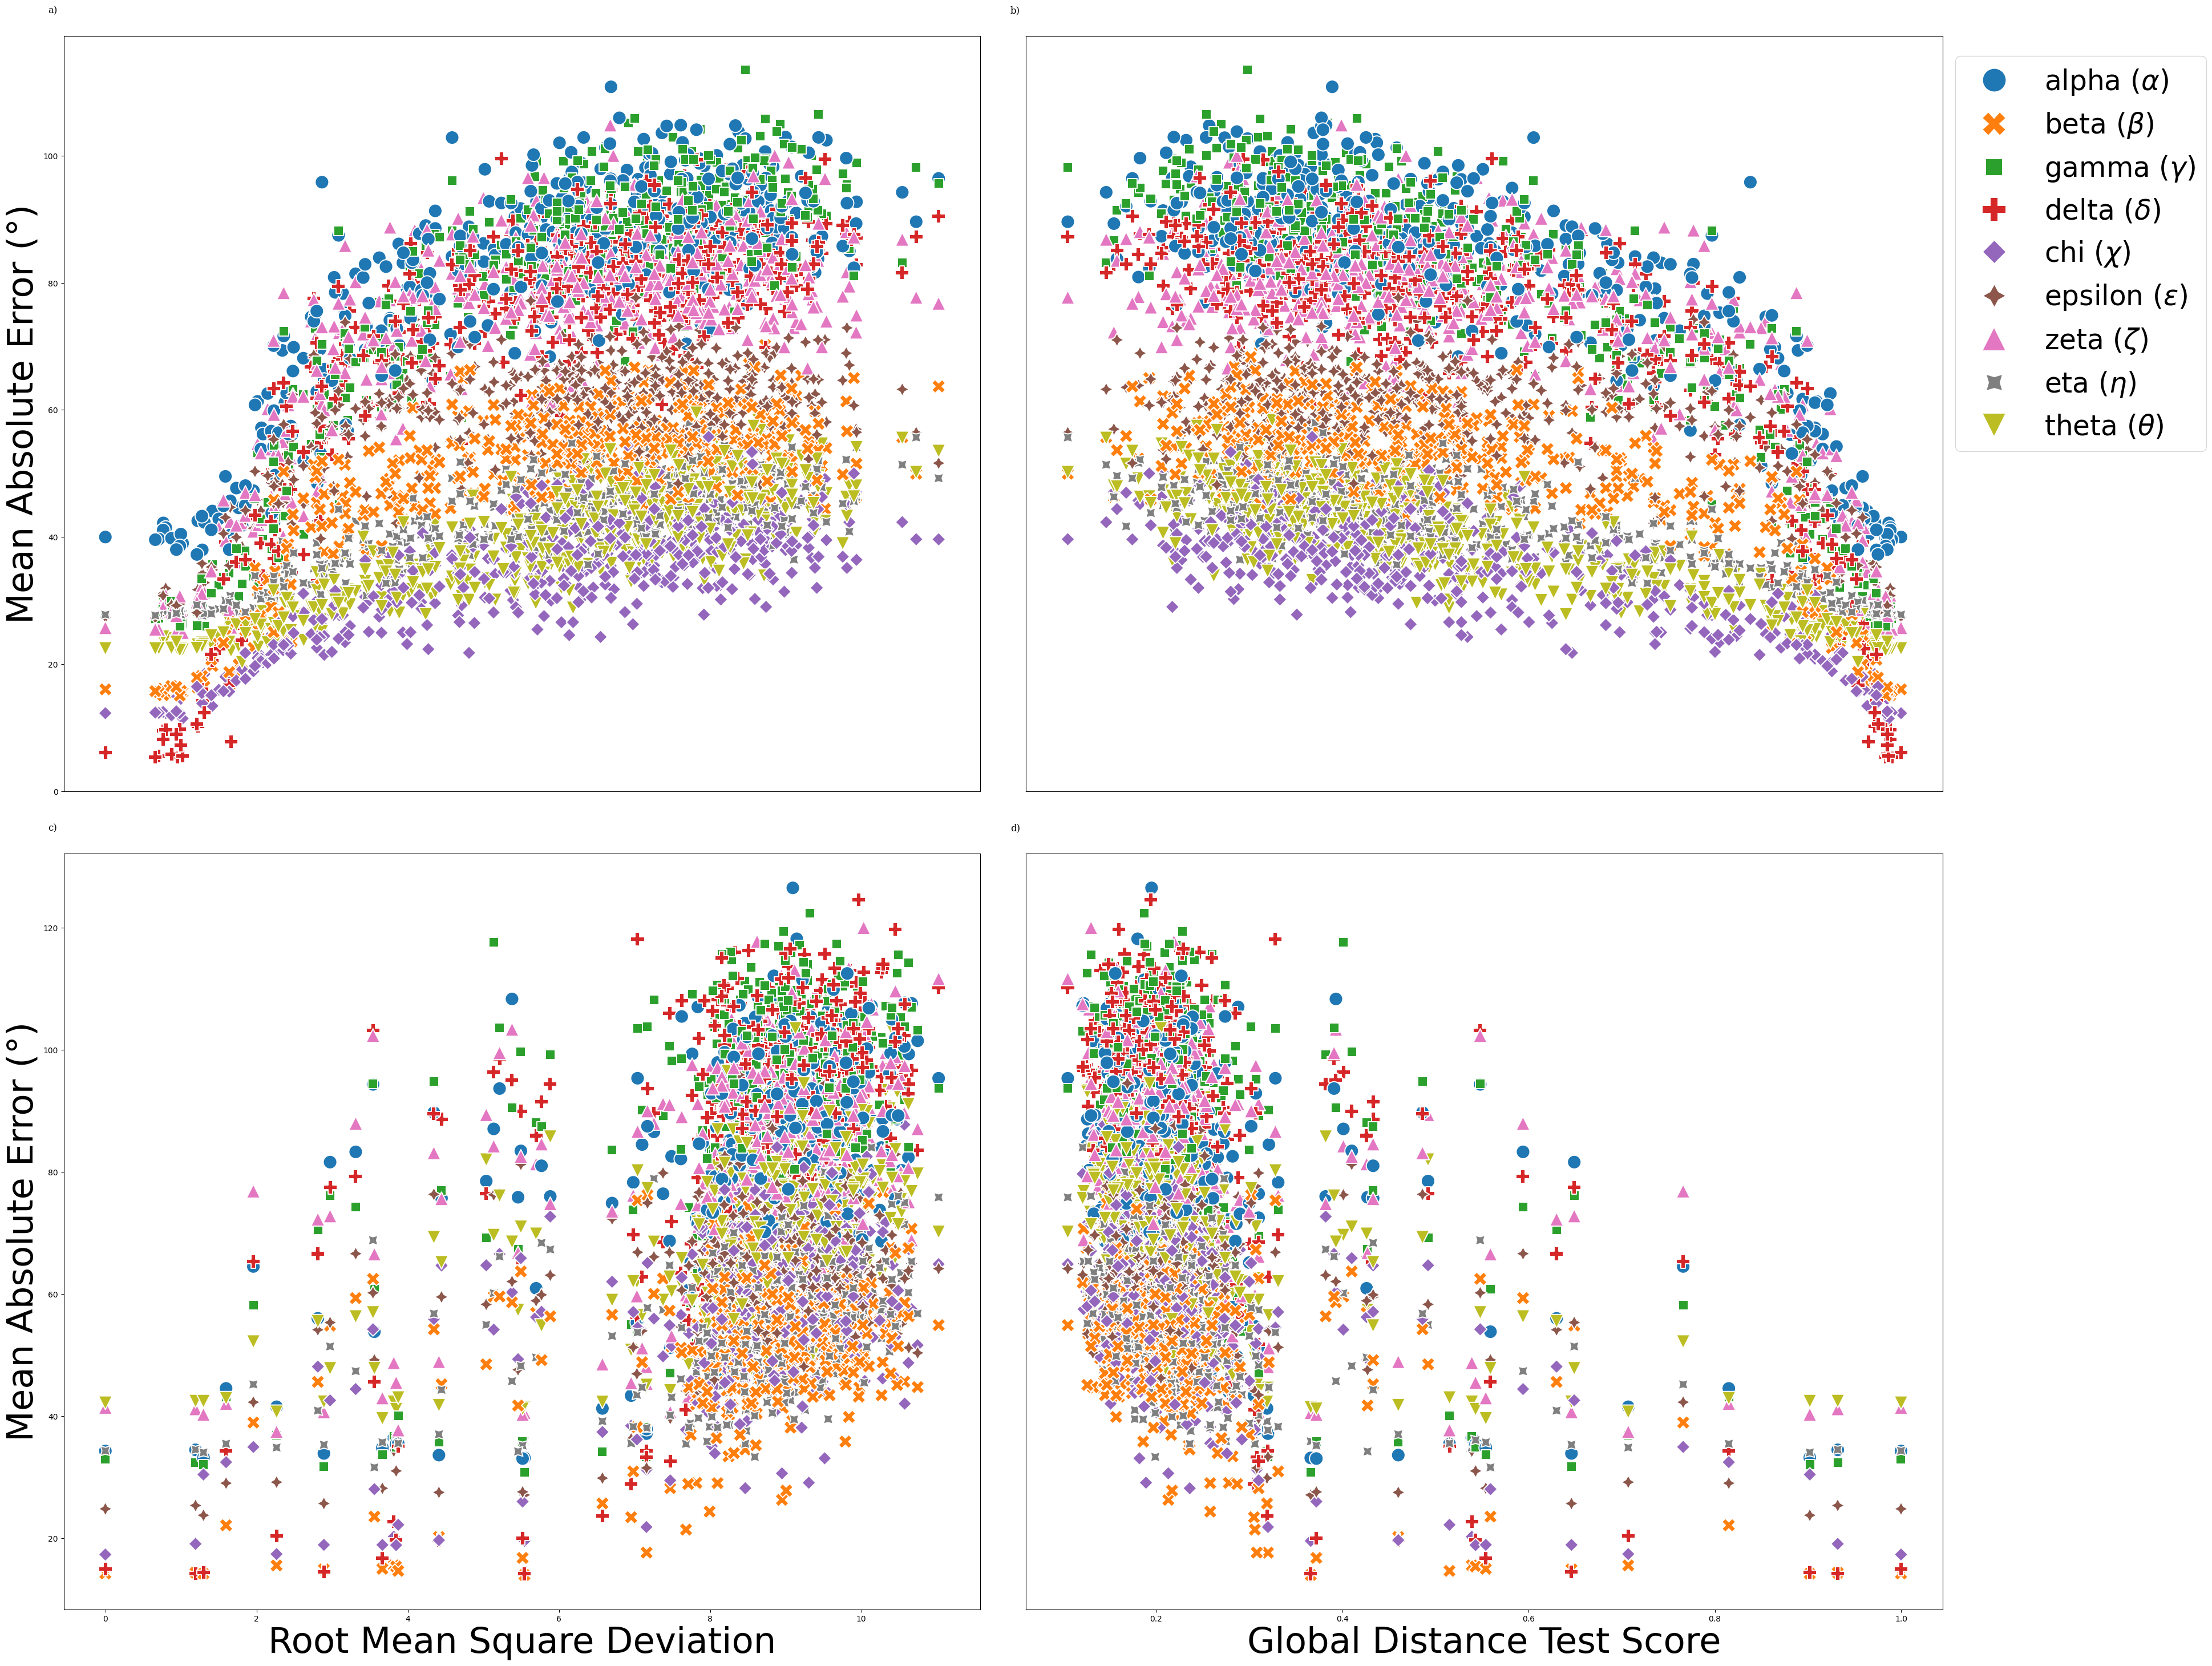

In [6]:
# fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(30, 30))

fig, axs = plt.subplot_mosaic([['a)', 'b)'], ['c)', 'd)']], layout='constrained', figsize=(35, 30))
((_, ax1), (_, ax2), (_, ax3), (_, ax4)) = axs.items()

for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.02, label, transform=ax.transAxes + trans,
            fontsize='large', va='bottom', fontfamily='serif')

plt.rcParams.update({'font.size': 35})
matplotlib.rc('xtick', labelsize=35) 
matplotlib.rc('ytick', labelsize=35)

sns.scatterplot(data=data_to_plot[0][1], x="RMSD", y="MAE", hue="Angle", style="Angle", ax=ax1, size="Angle", sizes=[300]*len(all_dihedral_angle_names))
sns.scatterplot(data=data_to_plot[0][1], x="GDT-ALL", y="MAE", hue="Angle", style="Angle", ax=ax2, size="Angle", sizes=[300]*len(all_dihedral_angle_names))
ax1.legend().set_visible(False)
ax1.set_xlabel('')
ax1.set_xticks([])
ax1.set_ylabel('Mean Absolute Error (°)', fontsize=45)
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_xticks([])
ax2.legend().set_visible(False)

sns.scatterplot(data=data_to_plot[1][1], x="RMSD", y="MAE", hue="Angle", style="Angle", ax=ax3, size="Angle", sizes=[300]*len(all_dihedral_angle_names))
sns.scatterplot(data=data_to_plot[1][1], x="GDT-ALL", y="MAE", hue="Angle", style="Angle", ax=ax4, size="Angle", sizes=[300]*len(all_dihedral_angle_names))
ax3.set_ylabel('Mean Absolute Error (°)', fontsize=45)
ax3.set_xlabel('Root Mean Square Deviation', fontsize=45)
ax3.legend().set_visible(False)
ax4.set_xlabel('Global Distance Test Score', fontsize=45)
ax4.set_ylabel('')
ax4.set_yticks([])
ax4.legend().set_visible(False)


# Get the handles and labels from the first subplot
all_handles = list()
all_labels = list()
handles, labels = ax1.get_legend_handles_labels()
for each_label_idx , each_label in enumerate(labels):
    if each_label not in all_labels:
        all_labels.append(each_label)
        all_handles.append(handles[each_label_idx])
        
legend = fig.legend(all_handles, all_labels, loc='upper right', bbox_to_anchor=(1.124, 0.963))

for handle in legend.legend_handles:
    # handle.set_sizes([6.0])
    handle.set_markersize(30)

# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles, labels, bbox_to_anchor=(1.23, 1.02), loc='upper right')

# fig.suptitle(f"MAE vs RMSD and MAE vs GDT plots of PDB ID {each_decoy_dir}")
plt.tight_layout()
plt.savefig(f'images/gdt_rmsd_mae.svg', dpi=300, bbox_inches='tight')
plt.show()